In this notebook, we train a SOMVAE where quantizer takes inputs from a sampled image from the usual continuous N(0,I) space in a VAE. The weights of this SOMVAE are initialized from the regular VAE encoder for mean and sd, and the codebook is initialized based on the regular AE encoder output.  

In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun  2 16:36:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os 
os.chdir('drive/MyDrive/OASIS_Data')

In [4]:
import copy 
import time
import datetime
import numpy as np 
import pandas as pd 
import nibabel as nib
import sklearn as skl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn 
from torch import optim

In [6]:
pip install torchio nilearn

     |████████████████████████████████| 153kB 8.3MB/s 
     |████████████████████████████████| 3.1MB 43.6MB/s 
     |████████████████████████████████| 42.5MB 124kB/s 


In [7]:
import torchio as tio 

In [8]:
os.chdir("MRI_SOMVAE")
from OASISDataset import *
from FullModels import *
from TrainingTesting import *
from ExtraMetrics import *
from RegularSOM import *
from plotting_tools import *
os.chdir("..")

Split data into train and val as before

In [9]:
fulltrainlist = pd.read_csv("oasis_ctrl_training.csv")

trainlist,vallist = train_test_split(fulltrainlist, random_state=128, test_size=0.15)

folder = "ctrl_original_resolution"

In [10]:
start = time.time()
traindataset = OASISDataset_Colab(folder,trainlist)
print(time.time()-start)
valdataset = OASISDataset_Colab(folder,vallist)
print(time.time()-start)

143.91927456855774
170.2737295627594


In [11]:
batch_size=32

train_dataloader = DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(valdataset,batch_size=len(valdataset),shuffle=True)

Load Regular AE for the encoder output used in K Means clustering to initialize the codebook

In [ ]:
AEcheckpoint = torch.load("VanillaAE32_Run2_4filters_051921.tar")

RegularAE = VanillaAE(num_channels=1,embedding_dim=32,num_filters=4,batchnorm=True)
RegularAE.load_state_dict(AEcheckpoint["model_state_dict"])
RegularAE.eval()

VanillaAE(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (decoder): VQDecoder(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, ep

In [ ]:
Xin1,Xout1 = next(iter(train_dataloader))
Xenc1 = RegularAE.encoder(Xin1)
Xenc1_flat = Xenc1.reshape(Xenc1.shape[0],Xenc1.shape[1],-1).permute(0,2,1).reshape(-1,Xenc1.shape[1]).detach().numpy()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
start = time.time()
Kmeans = KMeans(n_clusters=256)
Kmeans.fit(Xenc1_flat)
centers_start = torch.from_numpy(Kmeans.cluster_centers_)
print(time.time() - start)

52.47551894187927


Load VAE Model used for weight initialization 

In [ ]:
VAEcheckpoint = torch.load("VanillaVAE32_250epochs.tar")
RegularVAE = VanillaVAE(num_channels = 1,num_filters = 4,embedding_dim = 32)
RegularVAE.load_state_dict(VAEcheckpoint["model_state_dict"])
RegularVAE.eval()

VanillaVAE(
  (encoder_mu): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (encoder_sigma): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4

Checking SSIM and PSNR for Regular VAE 

In [ ]:
temp_trainSSIM = []
temp_trainPSNR = []
temp_valSSIM = []
temp_valPSNR = []


with torch.no_grad():
      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda:0" if use_cuda else "cpu")
      torch.backends.cudnn.benchmark = True
      if use_cuda:
        if torch.cuda.device_count() > 1:
          print("Let's use", torch.cuda.device_count(), "GPUs!")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
          RegularVAE = nn.DataParallel(RegularVAE) #NewVQVAE = nn.DataParallel(NewVQVAE)
      RegularVAE.to(device)#NewVQVAE.to(device)
      RegularVAE.eval()#NewVQVAE.eval()
      for Xin_train,Xout_train in train_dataloader:
          Xin_train,Xout_train = Xin_train.to(device), Xout_train.to(device)
          Xrecon_train = RegularVAE(Xin_train)["x_out"]#NewVQVAE(Xin_train)["x_out_ze"]
          train_psnr_batch = PSNR(Xout_train,Xrecon_train)
          temp_trainPSNR.append(train_psnr_batch)
          #if epoch % 2 == 0:
          train_ssim_batch = SSIM(Xout_train,Xrecon_train)
          temp_trainSSIM.append(train_ssim_batch)

      
      for Xin_val,Xout_val in val_dataloader:
          Xin_val,Xout_val = Xin_val.to(device),Xout_val.to(device)
          Xrecon_val = RegularVAE(Xin_val)["x_out"] #NewVQVAE(Xin_val)["x_out_ze"]
          val_psnr_batch = PSNR(Xout_val,Xrecon_val)
          temp_valPSNR.append(val_psnr_batch)
          #if epoch % 2 ==0:
          val_ssim_batch = SSIM(Xout_val,Xrecon_val)
          temp_valSSIM.append(val_ssim_batch)

In [ ]:
torch.cat(temp_trainSSIM).mean()

tensor(0.5724, device='cuda:0')

In [ ]:
torch.cat(temp_valSSIM).mean()

tensor(0.5811, device='cuda:0')

In [ ]:
torch.cat(temp_trainPSNR).mean()

tensor(19.3471, device='cuda:0')

In [ ]:
torch.cat(temp_valPSNR).mean()

tensor(20.0638, device='cuda:0')

Set up SOMVAEContinuous for training

In [ ]:
SOMVAEcont = SOMVAEContinuous(num_channels=1,num_filters=4,embedding_dim=32,num_embeddings=256,som_h=16,som_w=16,alpha = 6, beta =1,geometry="toroid",batchnorm=True)

In [ ]:
SOMVAEcont.encoder_mu = copy.deepcopy(RegularVAE.encoder_mu)
SOMVAEcont.encoder_sigma = copy.deepcopy(RegularVAE.encoder_sigma)

In [ ]:
SOMVAEcont.quantization._embedding.weight.data = copy.deepcopy(centers_start)

In [ ]:
SOMVAEcont.quantization._embedding.weight

Parameter containing:
tensor([[ 2.1337e-01, -8.2054e-01, -2.7257e-01,  ...,  1.7575e+00,
         -2.8581e+00,  1.3662e+00],
        [-2.2873e+00,  9.8399e-02,  8.4543e-01,  ..., -1.1007e+00,
         -2.2065e+01, -9.0324e-01],
        [ 1.3289e+00, -1.0848e+00, -9.8225e-01,  ..., -1.1277e+00,
         -1.4156e+01, -7.6665e-01],
        ...,
        [-4.5949e-01,  6.8911e-01, -2.5517e-01,  ..., -6.6908e-01,
         -1.6058e+01, -4.7072e-01],
        [-1.5017e-01, -9.1567e-01, -1.4072e-01,  ...,  5.2117e-01,
         -8.4768e+00,  3.3852e+00],
        [-1.5883e+00, -1.5705e+00,  3.7476e+00,  ..., -1.8589e-03,
         -1.7321e+01, -1.1855e+00]], requires_grad=True)

In [ ]:
optimizer = optim.Adam(SOMVAEcont.parameters(),lr=0.005)

max_epochs = 700
train_losses = np.zeros(max_epochs)
train_losses[:] = np.NaN 
val_losses = np.zeros(max_epochs)
val_losses[:] = np.NaN 

train_PSNR = copy.deepcopy(train_losses)
val_PSNR = copy.deepcopy(val_losses)

train_SSIM = copy.deepcopy(train_losses)
val_SSIM = copy.deepcopy(val_losses)

loss_function = nn.MSELoss(reduction="mean")

In [ ]:
for epoch in range(max_epochs):

  t0 = time.time()

  train_losses[epoch] = train_NewVQVAE(SOMVAEcont,optimizer,loss_function,train_dataloader, epoch,log_every_num_batches=5,lam_ze = 0.8, lam_zq = 0.2)

  val_losses[epoch] = test_NewVQVAE(SOMVAEcont,loss_function,val_dataloader)

  dtepoch = time.time() - t0

  print('====> Total time elapsed for this epoch: {:s}'.format(str(datetime.timedelta(seconds=int(dtepoch)))))

  if (epoch + 1) % 70 == 0:

    path = f"ContinuousSOMVAE32_256_4filters_{epoch + 1}epochs_toroid_053121.tar"

    torch.save({"epoch":epoch,"model_state_dict":SOMVAEcont.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"train_loss": train_losses,"val_loss":val_losses},path)

    print(f"Checkpointed at epoch {epoch + 1}")



Streaming output truncated to the last 5000 lines.

Train Epoch: 77 [1/4 (25%)]	Loss: 4.799970	ET - 0:00:27

====> Epoch: 77 Average loss: 4.7906	Time elapsed: 0:00:34
====> Test set loss: 6.6422	Time elapsed: 0:00:05

====> Total time elapsed for this epoch: 0:00:40
====> Begin epoch 78

Train Epoch: 78 [1/4 (25%)]	Loss: 4.773736	ET - 0:00:26

====> Epoch: 78 Average loss: 4.7644	Time elapsed: 0:00:34
====> Test set loss: 6.6020	Time elapsed: 0:00:05

====> Total time elapsed for this epoch: 0:00:40
====> Begin epoch 79

Train Epoch: 79 [1/4 (25%)]	Loss: 4.746200	ET - 0:00:26

====> Epoch: 79 Average loss: 4.7367	Time elapsed: 0:00:34
====> Test set loss: 6.5669	Time elapsed: 0:00:05

====> Total time elapsed for this epoch: 0:00:40
====> Begin epoch 80

Train Epoch: 80 [1/4 (25%)]	Loss: 4.720068	ET - 0:00:27

====> Epoch: 80 Average loss: 4.7118	Time elapsed: 0:00:34
====> Test set loss: 6.5306	Time elapsed: 0:00:05

====> Total time elapsed for this epoch: 0:00:40
====> Begin epoch 

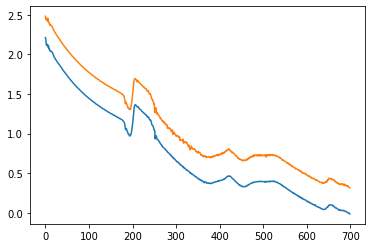

In [ ]:
plt.plot(np.log(train_losses))
plt.plot(np.log(val_losses))
plt.show()

In [ ]:
temp_trainSSIM = []
temp_trainPSNR = []
temp_valSSIM = []
temp_valPSNR = []


with torch.no_grad():
      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda:0" if use_cuda else "cpu")
      torch.backends.cudnn.benchmark = True
      if use_cuda:
        if torch.cuda.device_count() > 1:
          print("Let's use", torch.cuda.device_count(), "GPUs!")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
          SOMVAEcont = nn.DataParallel(SOMVAEcont) #NewVQVAE = nn.DataParallel(NewVQVAE)
      SOMVAEcont.to(device)#NewVQVAE.to(device)
      SOMVAEcont.eval()#NewVQVAE.eval()
      for Xin_train,Xout_train in train_dataloader:
          Xin_train,Xout_train = Xin_train.to(device), Xout_train.to(device)
          Xrecon_train = SOMVAEcont(Xin_train)["x_out_ze"]#NewVQVAE(Xin_train)["x_out_ze"]
          train_psnr_batch = PSNR(Xout_train,Xrecon_train)
          temp_trainPSNR.append(train_psnr_batch)
          #if epoch % 2 == 0:
          train_ssim_batch = SSIM(Xout_train,Xrecon_train)
          temp_trainSSIM.append(train_ssim_batch)

      
      for Xin_val,Xout_val in val_dataloader:
          Xin_val,Xout_val = Xin_val.to(device),Xout_val.to(device)
          Xrecon_val = SOMVAEcont(Xin_val)["x_out_ze"] #NewVQVAE(Xin_val)["x_out_ze"]
          val_psnr_batch = PSNR(Xout_val,Xrecon_val)
          temp_valPSNR.append(val_psnr_batch)
          #if epoch % 2 ==0:
          val_ssim_batch = SSIM(Xout_val,Xrecon_val)
          temp_valSSIM.append(val_ssim_batch)

In [ ]:
SSIMtrain = torch.cat(temp_trainSSIM).mean()
print(SSIMtrain)

SSIMval = torch.cat(temp_valSSIM).mean()
print(SSIMval)

tensor(0.6241, device='cuda:0')
tensor(0.6303, device='cuda:0')


In [ ]:
PSNRtrain = torch.cat(temp_trainPSNR).mean()
print(PSNRtrain)

PSNRval = torch.cat(temp_valPSNR).mean()
print(PSNRval)

tensor(19.8786, device='cuda:0')
tensor(20.5822, device='cuda:0')


In [ ]:
path

'ContinuousSOMVAE32_256_4filters_700epochs_toroid_053121.tar'

In [ ]:
torch.save({"epoch":epoch,"model_state_dict":SOMVAEcont.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"train_loss": train_losses,"val_loss":val_losses,
            "train_SSIM": SSIMtrain,"val_SSIM": SSIMval, "train_PSNR": PSNR_train,"val_PSNR": PSNR_val},
           "ContinuousSOMVAE32_256_4filters_700epochs_toroid_053121.tar")

In [ ]:
SOMresult = pd.DataFrame({"train_losses":train_losses, "val_losses":val_losses})
SOMresult

,train_losses,val_losses
0,9.132032,11.952507
1,8.955189,11.539200
2,8.346453,11.438274
3,8.259174,11.667816
4,8.341756,11.364697
...,...,...
695,1.002551,1.394801
696,0.996772,1.394563
697,0.998339,1.377196
698,0.994023,1.374882


In [ ]:
SOMresult.to_csv("ContinuousSOMVAE32_256_4filters_700epochs_toroid_053121.csv",index=False)